In [2]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import alibi as ab
from alibi.explainers import AnchorTabular
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

In [5]:
print(df.head())

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [6]:
print("\nChecking for missing values:")
print(df.isnull().sum())


Checking for missing values:
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64


In [7]:
print("\nData types:")
print(df.dtypes)


Data types:
sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object


In [8]:
le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])
print("\nTransformed DataFrame with numerical labels:")
print(df.head())


Transformed DataFrame with numerical labels:
   sepal_length  sepal_width  petal_length  petal_width  species
0           5.1          3.5           1.4          0.2        0
1           4.9          3.0           1.4          0.2        0
2           4.7          3.2           1.3          0.2        0
3           4.6          3.1           1.5          0.2        0
4           5.0          3.6           1.4          0.2        0


In [9]:
# Split the data
X = df.drop('species', axis=1)
y = df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
feature_names = X.columns.tolist()
predict_fn = lambda x: clf.predict_proba(x)
explainer = AnchorTabular(predict_fn, feature_names=feature_names)
explainer.fit(X_train, disc_perc=(25, 50, 75))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.9.6'}
)

In [13]:
# Explain a prediction
idx = 0  # Index of the instance to explain
explanation = explainer.explain(X_test[idx].reshape(1, -1), threshold=0.95)
print("\nExplanation for the instance:")
print(explanation)


Explanation for the instance:
Explanation(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {
              'seed': None,
              'disc_perc': (25, 50, 75),
              'threshold': 0.95,
              'delta': 0.1,
              'tau': 0.15,
              'batch_size': 100,
              'coverage_samples': 10000,
              'beam_size': 1,
              'stop_on_first': False,
              'max_anchor_size': None,
              'min_samples_start': 100,
              'n_covered_ex': 10,
              'binary_cache_size': 10000,
              'cache_margin': 1000,
              'verbose': False,
              'verbose_every': 1,
              'kwargs': {}}
            ,
  'version': '0.9.6'}
, data={
  'anchor': ['sepal_width <= -0.14', '-1.18 < petal_width <= 0.16', 'sepal_length > -0.07'],
  'precision': 1.0,
  'coverage': 0.0653,
  'raw': {
           'feature': [1, 3, 0],
           'mean': [0.3671908202294943, 0.491467

In [14]:
# Feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

(-1.0, 4.0)

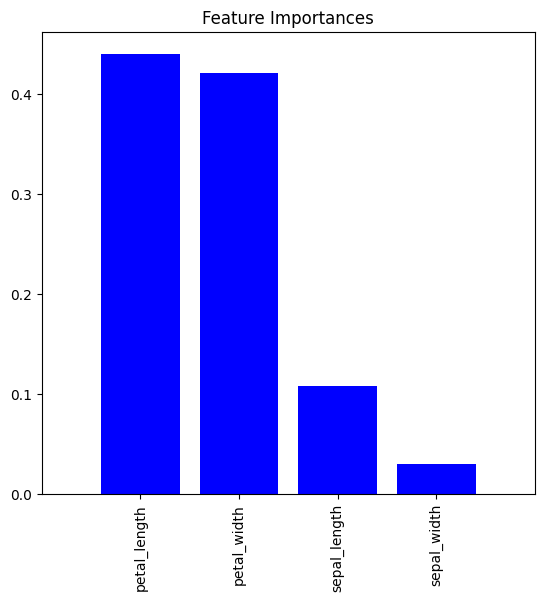

In [15]:
# Plotting feature importances with Matplotlib
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])

In [16]:
# Anchor explanation details
anchor_features = explanation.data['anchor']
precision = explanation.data['precision']
coverage = explanation.data['coverage']

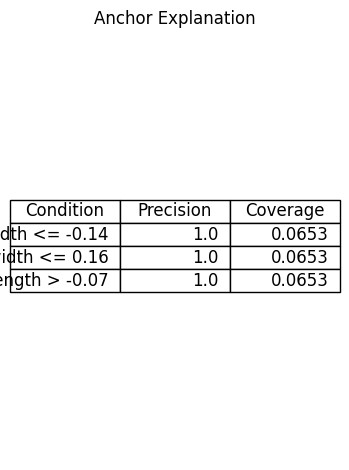

In [17]:
# Create a table for anchor explanation
plt.subplot(1, 2, 2)
plt.title("Anchor Explanation")
cell_text = [[f, precision, coverage] for f in anchor_features]
plt.axis('off')
table = plt.table(cellText=cell_text, colLabels=['Condition', 'Precision', 'Coverage'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.tight_layout()
plt.show()

In [18]:
# Plotly visualizations

# Create a bar plot for feature importances
feature_importances = go.Bar(
    x=[feature_names[i] for i in indices],
    y=importances[indices],
    marker=dict(color=importances[indices], colorscale='Viridis'),
    name='Feature Importances'
)
fig_importances = go.Figure(data=feature_importances)
fig_importances.update_layout(
    title='Feature Importances',
    xaxis_title='Features',
    yaxis_title='Importance'
)



In [19]:
# Show the feature importances figure
fig_importances.show()

# Anchor explanation table with Plotly
anchor_table = go.Figure(data=[go.Table(
    header=dict(values=['Condition', 'Precision', 'Coverage']),
    cells=dict(values=[anchor_features, [f"{precision:.2f}"] * len(anchor_features), [f"{coverage:.2f}"] * len(anchor_features)])
)])
anchor_table.update_layout(
    title='Anchor Explanation'
)
anchor_table.show()
